In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

In [0]:
from matplotlib.colors import ListedColormap


def draw_clf(model, X, y, meshgrid_steps=100, meshgrid_padding=0.05, fig_size=(6, 6), c_lightering=0.3, 
             feature_names=None, target_names=None, title=None, raw_data=False):

    x0_min, x0_max = np.min(X[:, 0]), np.max(X[:, 0])
    x1_min, x1_max = np.min(X[:, 1]), np.max(X[:, 1])

    x0_delta = (x0_max - x0_min) * meshgrid_padding
    x1_delta = (x1_max - x1_min) * meshgrid_padding

    x0_values = np.linspace(x0_min - x0_delta, x0_max + x0_delta, meshgrid_steps);
    x1_values = np.linspace(x1_min - x1_delta, x1_max + x1_delta, meshgrid_steps);

    xx0, xx1 = np.meshgrid(x0_values, x1_values)
    z = model.predict(np.c_[xx0.ravel(), xx1.ravel()])
    z = z.reshape(xx0.shape)

    current_palette = np.array(sns.color_palette()[:len(np.unique(y))])
    lighter_pallete = ListedColormap(current_palette + (1 - current_palette) * c_lightering)

    if raw_data:
        return xx0, xx1, z, lighter_pallete

    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    
    ax.pcolormesh(xx0, xx1, z, cmap=lighter_pallete)

    labels = [f'class {x} - {target_names[x]}' if isinstance(target_names, (np.ndarray, list)) else f'class {x}' 
              for x in range(len(np.unique(y)))]

    for idx, lbl in enumerate(labels):
        ax.scatter(X[np.where(y==idx), 0], X[np.where(y==idx), 1], label=lbl, ec='w')
        ax.legend()

    ax.set_xlabel(feature_names[0] if feature_names else 'x0')
    ax.set_ylabel(feature_names[1] if feature_names else 'x1')
    
    if title:
        ax.set_title(title)

    return fig, ax

## AdaBoost

https://www.youtube.com/watch?v=LsK-xG1cLYA

---
**Weight error rate:**

$r_j = \frac{\sum_{i=1}^mw^{(i)}\text{, where } y_j^{(i)} \ne  y^{(i)} }{\sum_{i=1}^mw^{(i)}}$

<br>

**Amount of say:**

$\alpha_j = \eta \log(\frac{1-r_j}{r_j})$

where $\eta$ - learning rate

<br>

**Weight update rule:**

- to increase value of sample:

$w^{(i)} = w^{(i)} \exp(\alpha_j)$

- to decrease value of sample:

$w^{(i)} = w^{(i)} \exp(-\alpha_j)$

then all weight are normalized (divide by $\sum_{i=1}^mw^{(i)}$)



$\left( \right)$


In [0]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=250, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y)

Train score: 1.0
Test score: 0.8412698412698413


(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68a2ae4668>)

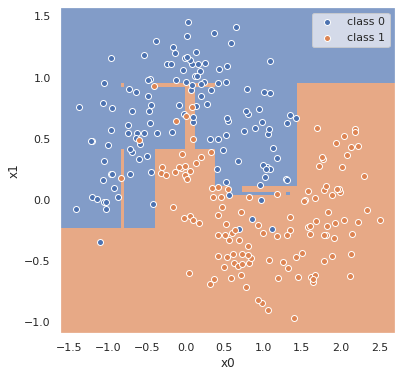

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# AdaBoost with use stump model (DecisionTreeClassifier with depth == 1)
ada_clf = AdaBoostClassifier(n_estimators=500, algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

print(f'Train score: {accuracy_score(y_train, ada_clf.predict(X_train))}')
print(f'Test score: {accuracy_score(y_test, ada_clf.predict(X_test))}')

draw_clf(ada_clf, X, y)

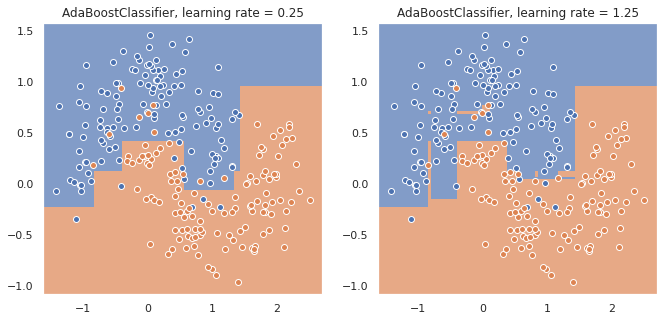

In [5]:
from sklearn.neighbors import KNeighborsClassifier

learning_rates = [0.25, 1.25]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

for learning_rate, ax in zip(learning_rates, axes):

    model = AdaBoostClassifier(learning_rate=learning_rate)
    model.fit(X_train, y_train)

    xx0, xx1, z, pallete = draw_clf(model, X, y, raw_data=True)
    ax.pcolormesh(xx0, xx1, z, cmap=pallete)
    ax.scatter(X[np.where(y==0), 0], X[np.where(y==0), 1], ec='w')
    ax.scatter(X[np.where(y==1), 0], X[np.where(y==1), 1], ec='w')
    ax.set_title(f'{model.__class__.__name__}, learning rate = {learning_rate:.2f}')

## Gradient Boost

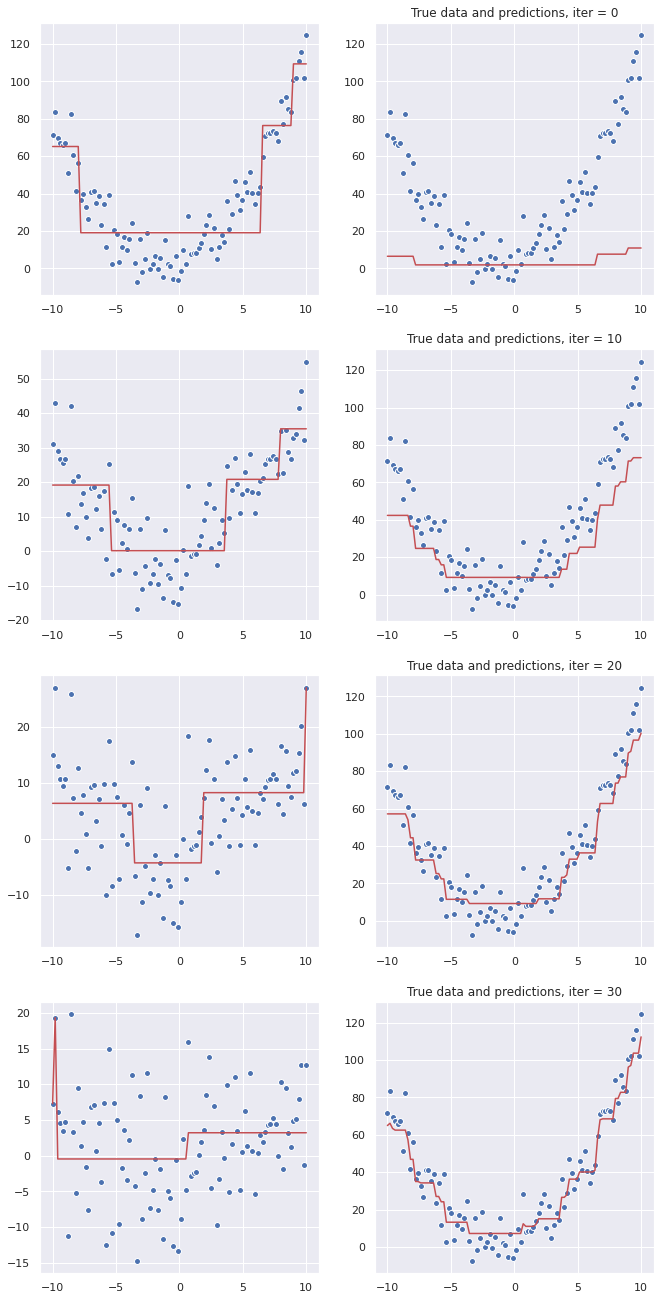

In [54]:
from sklearn.tree import DecisionTreeRegressor

t = np.linspace(-10, 10, 100)
X = t.reshape(-1, 1)
y = t ** 2 + + 2 * t + 1 + 10 * np.random.randn(100)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(11, 23))

y_predictions = []
models = []
y_ = y.copy()
learning_rate = 0.1

for ii in np.arange(31):
    new_model = DecisionTreeRegressor(max_depth=2)
    new_model.fit(X, y_)
    models.append(new_model)

    y_pred = new_model.predict(X)
    y_predictions.append(y_pred)
    y_pred_ensamble = sum([model.predict(X) for model in models]) * learning_rate

    if not ii % 10:
        draw_idx = int(ii / 10)
        axes[draw_idx][0].scatter(X, y_, ec='w')
        axes[draw_idx][1].scatter(X, y, ec='w')
        axes[draw_idx][0].plot(X, y_pred, 'r')
        axes[draw_idx][1].plot(X, y_pred_ensamble, 'r')
        axes[draw_idx][1].set_title(f'Learning data, iter = {ii}')
        axes[draw_idx][1].set_title(f'True data and predictions, iter = {ii}')

    y_ = y_ - learning_rate * y_pred

Text(0.5, 1.0, 'mean squared error')

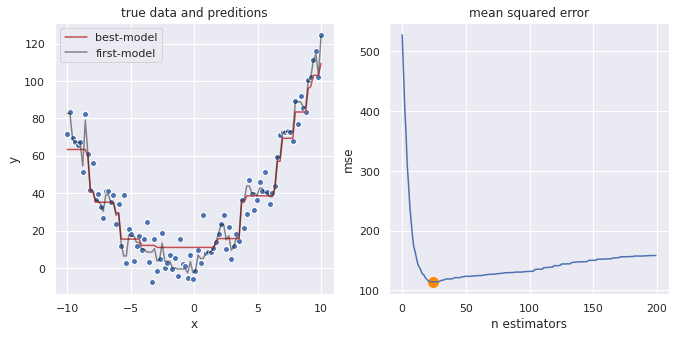

In [78]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

grad_tree = GradientBoostingRegressor(max_depth=2, n_estimators=200)
grad_tree.fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred) for y_pred in grad_tree.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)
min_error = np.min(errors)

best_grad_tree = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
best_grad_tree.fit(X_train, y_train)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

axes[0].scatter(X, y, ec='w')
axes[0].plot(t, best_grad_tree.predict(X), 'r', label='best-model')
axes[0].plot(t, grad_tree.predict(X), 'k', alpha=0.5, label='first-model')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('true data and preditions')
axes[0].legend()


axes[1].plot(errors)
axes[1].scatter(best_n_estimators, min_error, c='darkorange', s=100)
axes[1].set_xlabel('n estimators')
axes[1].set_ylabel('mse')
axes[1].set_title('mean squared error')